## Thats a crazy story

In [8]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
import configparser
import os
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import plotly_express as px
import seaborn as sns; sns.set()
import configparser
config = configparser.ConfigParser()
config.read("../../../env-sample.ini")
data_home = '/Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data'
output_dir = '/Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/output'
local_lib = '/Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/DS5001-2025-01-R/lessons/lib'
import sys
sys.path.append(local_lib)
from textparser import TextParser

clip_pats = [
    r"\*\*\*\s*START OF",
    r"\*\*\*\s*END OF"
]

# All are 'chap'and 'm'
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
ohco_pat_list = [
    (5200,   rf"^\s*CHAPTER\s+{roman}\s*$"), #Metamorphosis
    (7849,   rf"^\s*{roman}\s*$"), #The Trial
    (6969,  rf"^\s*LETTER .* to .*$"), # The Castle
    (6262,   rf"^CHAPTER\s+{roman}$"), # Amerika
    (6161,   rf"^CHAPTER\s+\d+$"), # The Judgement
    (6060,   rf"^Chapter\s+\d+$"), # Dearest Father
    (6363,  rf"^Chapter\s+\d+$"), # In the Penal colony
    (6464,   rf"^CHAPTER\s+\d+$"), # The Hunger Artist
    (6565, rf"^\s*CHAPTER\s+{roman}\."), # The Jackals and Arabs
    (6666, rf"^\s*CHAPTER\s+{roman}\s*$"), # A Country Doctor
    (6767, rf"^\s*CHAPTER\s+{roman}\s*$"), # An Imperial Message
    (5959,  rf"^(?:ETYMOLOGY|EXTRACTS|CHAPTER)"), # A report for an Academy
    (5858,  rf"^\s*CHAPTER\s+{roman}\.\s*$"), # The Great Wall of China
    (5757, rf"^\s*{roman}\.\s*$"), # The Hunter Gracchus
    (5656,  rf"^\s*{roman}\. .*$"), # Up in the Gallery
    (5555, rf"^CHAPTER\s+{roman}\.?$"), # Before the Law
    (5454, rf"^\s*[A-Z,;-]+\.\s*$"), # Josephine the Songstress
    (5353,  rf"^CHAPTER "), # The Burrow
    (5252, rf"^CHAPTER\s+{roman}\.\s*$"), # Blumfeld
    (23532, rf"Chapter\s+{roman}") # Meditation
]
chapter_regexes = [
    (5200,   rf"^\s*{roman}\s*$"),
    (7849,   rf"^\s*Chapter\s+(?:One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten)\s*$"),
    (6969,   rf"^\s*\d+\s*$"),
    (6262,   rf"^\s*\d+\s*$"),
    (6161,   "NOCHAPTERS"),
    (6060,   "NOCHAPTERS"),
    (6363,   "NOCHAPTERS"),
    (6464,   "NOCHAPTERS"),
    (6565,   "NOCHAPTERS"),
    (6666,   "NOCHAPTERS"),
    (6767,   "NOCHAPTERS"),
    (5959,   "NOCHAPTERS"),
    (5858,   "NOCHAPTERS"),
    (5757,   "NOCHAPTERS"),
    (5656,   "NOCHAPTERS"),
    (5555,   "NOCHAPTERS"),
    (5454,   "NOCHAPTERS"),
    (5353,   "NOCHAPTERS"),
    (5252,   "NOCHAPTERS"),
    (23532,  rf"^(Children on the country road|Unmasking a con artist|The Sudden Walk|Resolutions|The trip to the mountains|The Bachelor's Misfortune|The Merchant|Distracted Looking Out|The Way Home|The Passers-by|Passenger|Dresses|The rejection|Food for thought for gentlemen riders|The Alley Window|Desire to become an Indian|The Trees|Unhappiness)$")  # Poem title on line 1
]
ohco_pat_list = chapter_regexes
source_files = f'{data_home}'
source_file_list = sorted(glob(f"{source_files}/*.*"))

book_data = []
for source_file_path in source_file_list:
    # Get the filename only, e.g. 'pg5353.txt'
    filename = os.path.basename(source_file_path)
    # Extract the numeric ID from the filename (remove 'pg' and '.txt')
    book_id = int(filename.replace('pg', '').replace('.txt', ''))
    # Use filename (without extension) as a raw title (optional: clean further)
    book_title = filename.replace('.txt', '').replace('_', ' ')
    # Append a tuple of (book_id, path, title)
    book_data.append((book_id, source_file_path, book_title))
# Convert to DataFrame
LIB = pd.DataFrame(book_data, columns=['book_id', 'source_file_path', 'raw_title']) \
        .set_index('book_id') \
        .sort_index()
book_titles = {
    5200: "Metamorphosis",
    7849: "The Trial",
    6969: "The Castle",
    6262: "Amerika",
    6161: "The Judgement",
    6060: "Dearest Father",
    6363: "In the Penal Colony",
    6464: "The Hunger Artist",
    6565: "The Jackals and Arabs",
    6666: "A Country Doctor",
    6767: "An Imperial Message",
    5959: "A Report for an Academy",
    5858: "The Great Wall of China",
    5757: "The Hunter Gracchus",
    5656: "Up in the Gallery",
    5555: "Before the Law",
    5454: "Josephine the Songstress",
    5353: "The Burrow",
    5252: "Blumfeld",
    23532: "Meditation"
}
book_titles = {f'pg{key}': value for key, value in book_titles.items()}
try:
    LIB['author'] = 'KAFKA, FRANZ'
    LIB['title'] = LIB.raw_title.replace(book_titles).str.upper()
    LIB = LIB.drop('raw_title', axis=1)
except AttributeError:
    pass
LIB['chap_regex'] = LIB.index.map(pd.Series({x[0]:x[1] for x in ohco_pat_list}))
LIB
# This cell takes 16 seconds to run
def tokenize_collection(LIB):

    clip_pats = [
        r"\*\*\*\s*START OF",
        r"\*\*\*\s*END OF"
    ]

    books = []
    for book_id in LIB.index:

        # Announce
        print("Tokenizing", book_id, LIB.loc[book_id].title)

        # Define vars
        chap_regex = LIB.loc[book_id].chap_regex
        ohco_pats = [('chap', chap_regex, 'm')]
        src_file_path = LIB.loc[book_id].source_file_path

        # Create object
        text = TextParser(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats, use_nltk=True)
        # text = TextImporter(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats) 

        # Define parameters
        text.verbose = True
        text.strip_hyphens = True
        text.strip_whitespace = True

        # Parse
        text.import_source().parse_tokens();

        # Name things
        text.TOKENS['book_id'] = book_id
        text.TOKENS = text.TOKENS.reset_index().set_index(['book_id'] + text.OHCO)

        # Add to list
        books.append(text.TOKENS)
        
    # Combine into a single dataframe
    CORPUS = pd.concat(books).sort_index()

    # Clean up
    del(books)
    del(text)
        
    print("Done")
        
    return CORPUS
CORPUS = tokenize_collection(LIB)

Tokenizing 5200 METAMORPHOSIS
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5200.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^\s*[IVXLCM]+\s*$
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 5252 BLUMFELD
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5252.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone NOCHAPTERS
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 5353 THE BURROW
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5353.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone NOCHAPTERS
li

c:\Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/DS5001-2025-01-R/lessons/lib\textparser.py:132: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  div_lines = self.TOKENS[src_col].str.contains(div_pat, regex=True, case=True)


Done


In [4]:
CORPUS = CORPUS[CORPUS.term_str != '']
CORPUS['pos_group'] = CORPUS.pos.str[:2]
CORPUS

pos_tuple  pos token_str  \
book_id chap_id para_num sent_num token_num                                  
5200    1       1        0        0               (One, CD)   CD       One   
                                  1          (morning,, NN)   NN  morning,   
                                  2             (when, WRB)  WRB      when   
                                  3           (Gregor, NNP)  NNP    Gregor   
                                  4            (Samsa, NNP)  NNP     Samsa   
...                                                     ...  ...       ...   
23532   10      39       0        27         (upstairs, JJ)   JJ  upstairs   
                                  28              (and, CC)   CC       and   
                                  29               (go, VB)   VB        go   
                                  30               (to, TO)   TO        to   
                                  31           (sleep., VB)   VB    sleep.   

                                             term_str pos_group  
book_id chap_id para_num sent_num token_num                      
5200    1       1        0        0               one        CD  
                                  1           morning        NN  
                                  2              when        WR  
                                  3            gregor        NN  
                                  4             samsa        NN  
...                                               ...       ...  
23532   10      39       0        27         upstairs        JJ  
                                  28              and        CC  
                                  29               go        VB  
                                  30               to        TO  
                                  31            sleep        VB  

[423144 rows x 5 columns]

- Columns (as delimitted names, including `n`, `p`', `i`, `dfidf`, `porter_stem`, `max_pos` and `max_pos_group`, `stop`):
- Note: Your VOCAB may contain ngrams. If so, add a feature for `ngram_length`.
- List the top 20 significant words in the corpus by DFIDF.

In [ ]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['max_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['n_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack().count(1)
VOCAB['cat_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos_group.apply(lambda x: set(x))
VOCAB['n_pos'] = CORPUS[['term_str','pos']].value_counts().unstack().count(1)
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['porter_stem'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

VOCAB

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,stop,porter_stem,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,,
1,1,1,0.000002,18.690615,JJ,JJ,1,{JJ},1,{JJ},0,1,1,1
10,1,2,0.000002,18.690615,CD,CD,1,{CD},1,{CD},0,10,10,10
15,1,2,0.000002,18.690615,CD,CD,1,{CD},1,{CD},0,15,15,15
2,1,1,0.000002,18.690615,NN,NN,1,{NN},1,{NN},0,2,2,2
25,1,2,0.000002,18.690615,CD,CD,1,{CD},1,{CD},0,25,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ﬂung,6,4,0.000014,16.105653,NNP,NN,4,"{JJ, NN, VB, IN}",5,"{JJ, NN, NNP, VBP, IN}",0,ﬂung,ﬂung,ﬂung
ﬂushed,1,6,0.000002,18.690615,NN,NN,1,{NN},1,{NN},0,ﬂush,ﬂush,ﬂush
ﬂuttered,1,8,0.000002,18.690615,VBN,VB,1,{VB},1,{VBN},0,ﬂutter,ﬂutter,ﬂut


In [6]:
ngram_order = 3 # 3 means trigrams
pads = ["<s>", "</s>"]
widx = [f"w{i}" for i in range(ngram_order)]
ohco = ['sent_num', 'token_num']
train_file = CORPUS.reset_index()
train_ohco = "book_id  chap_id  para_num  sent_num  token_num".split()
train_df = train_file.set_index(train_ohco)
train_tokens = train_df.groupby(train_ohco[:4]).term_str.apply(list).values.tolist()
# 2D list to hold our resulting ngrams
train_ngrams = [[] for i in range(ngram_order)] 

# Arguments to pass
ngram_args = dict(
    pad_right=True, 
    pad_left=True, 
    left_pad_symbol=pads[0], 
    right_pad_symbol=pads[1]
)

# Apply the function to each sentence
for j in range(ngram_order):
    train_ngrams[j] = [nltk.ngrams(sent, n=j+1, **ngram_args) for sent in train_tokens]
ng_cols = ['sent_num', 'token_num', 'word_pos', 'token']
ng_data = [[] for n in range(ngram_order)] # Temporary list of lists to hold tokens
ng_df = [None for n in range(ngram_order)] # For list of data frames
for n in range(ngram_order):
    for i, z in enumerate(train_ngrams[n]):
        for j, x in enumerate(list(z)):
            for k, token in enumerate(list(x)):
                ng_data[n].append((i, j, f"w{k}", token))
    ng_df[n] = pd.DataFrame(ng_data[n], columns=ng_cols).set_index(ng_cols[:-1]).unstack()
    ng_df[n].columns = ng_df[n].columns.droplevel(0)

ng_counts = []
for n in range(ngram_order):
    ng_counts.append(ng_df[n].value_counts().to_frame('n'))
    
    df = ng_df[n].value_counts().to_frame('n')
    if n > 0:
        print(df.head())
        print(df.index.nlevels)
        df.index = pd.MultiIndex.from_tuples(df.index)
        df1 = df.n.unstack(fill_value=0)
        df2 = (df1.T / df1.T.sum()).T
        ng_counts.append(df2)
    else:
        ng_counts.append(df)

            n
w0  w1       
of  the  2125
in  the  1932
to  the  1325
<s> the  1152
    but  1098
2
                n
w0  w1  w2       
<s> <s> the  1152
        but  1098
        i    1057
        he    975
        and   849
3


ValueError: negative dimensions are not allowed

In [ ]:
# Functions to create TFIDF:
# Bring into your notebook the functions you created previously to generate a BOW table and compute TFIDF values. 
# Extend the TFIDF function so that it also returns the DFIDF value for each term in the VOCAB.
def gather_docs(CORPUS, ohco_level, term_col='term_str'):
    OHCO = CORPUS.index.names
    CORPUS[term_col] = CORPUS[term_col].astype('str')
    DOC = CORPUS.groupby(OHCO[:ohco_level])[term_col].apply(lambda x:' '.join(x)).to_frame('doc_str')
    return DOC

def BOW(tokendf, ocholevel):
    return tokendf.groupby(bags[ocholevel]+['term_str']).term_str.count().to_frame('n') 

def BOWtoTFIDF(BOW, tf_method, CORPUS, ocholevel = 2):
    
    # I added another parameter for the CORPUS because otherwise it becomes really tedious to undo the BOW function

    DTCM = BOW.n.unstack(fill_value=0)
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T
    DF = DTCM.astype('bool').sum() 
    N = DTCM.shape[0]
    IDF = IDF = np.log2(N / DF)
    TFIDF = TF * IDF
    # Extend the TFIDF function so that it also returns the DFIDF value for each term in the VOCAB.

    # We can adjust ocho level here if we want to, default is 2
    DOC = gather_docs(CORPUS, 2)
    DOC['n_tokens'] = DOC.doc_str.apply(lambda x: len(x.split()))
    ngram_range = (1,2)
    n_terms = 4000
    count_engine = CountVectorizer(
        stop_words = 'english',
        ngram_range = ngram_range,
        max_features = n_terms)
    X = count_engine.fit_transform(DOC.doc_str)
    DTM = pd.DataFrame(X.toarray(), 
    columns=count_engine.get_feature_names_out(), 
    index=DOC.index)
    VOCAB = DTM.sum().to_frame('n')
    VOCAB.index.name = 'term_str'
    VOCAB['df'] = DTM.astype(bool).sum()
    VOCAB['dfidf'] = VOCAB.df * np.log2(len(DTM)/VOCAB.df)
    VOCAB['dp'] = VOCAB.df / len(DTM)
    VOCAB['di'] = np.log2(1/VOCAB.dp)
    VOCAB['dh'] = VOCAB.dp * VOCAB.di
    VOCAB['n_chars'] = VOCAB.apply(lambda x: len(x.name), 1)
    VOCAB['n_tokens'] = VOCAB.apply(lambda x: len(x.name.split()), 1)
    VOCAB.sort_index()


    #Hopefully this join works but I'm actually not too sure this will work
    
    return TFIDF,VOCAB,DTM

# I think I'm going to use this oneliner more.
# get_tfidf = lambda X, agg_func='sum': (X.T / X.T.agg(agg_func)).T * (np.log2(len(X)/X.astype('bool').sum()))
OHCO = ['book_id','chap_id', 'para_num', 'sent_num', 'token_num']

bags = dict(
    SENTS = OHCO[:4],
    PARAS = OHCO[:3],
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)
tables = BOWtoTFIDF(BOW(CORPUS,'CHAPS'),'max', CORPUS, 2)
DTM = tables[2]
DFIDF = tables[1]
TFIDF = tables[0]

In [39]:
BOWofCORPUS = BOW(CORPUS,'CHAPS')
BOWofCORPUS

n
book_id chap_id term_str       
5200    1       a           108
                abandoning    1
                able          7
                about        16
                above         2
...                         ...
23532   10      you          55
                your          7
                youre         8
                yourself      2
                youve         1

[80573 rows x 1 columns]

In [23]:
DTM

term_str         abandoned  abandoning  abilities  ability  able  able make  \
book_id chap_id                                                               
5200    1                0           1          0        0     7          0   
        2                1           1          0        1    13          0   
        3                1           0          0        0     3          0   
5252    1                1           1          0        0     4          0   
5353    1                0           0          1        1     5          0   
...                    ...         ...        ...      ...   ...        ...   
23532   6                0           0          0        0     0          0   
        7                0           0          0        0     0          0   
        8                0           0          0        0     1          0   
        9                0           0          0        0     1          0   
        10               1           0          0        0     1          0   

term_str         abruptly  absence  absent  absolute  ...  ﬁre  ﬁre brigade  \
book_id chap_id                                       ...                     
5200    1               0        0       0         0  ...    0            0   
        2               0        0       0         0  ...    0            0   
        3               1        0       0         0  ...    0            0   
5252    1               0        1       0         0  ...    0            0   
5353    1               0        6       0         0  ...    0            0   
...                   ...      ...     ...       ...  ...  ...          ...   
23532   6               0        0       0         0  ...    0            0   
        7               0        0       0         0  ...    0            0   
        8               0        0       0         0  ...    0            0   
        9               0        0       0         0  ...    0            0   
        10              0        0       0         0  ...    0            0   

term_str         ﬁre engine  ﬁrmly  ﬁrst  ﬁrst time  ﬁst  ﬁt  ﬁxed  ﬂoor  
book_id chap_id                                                           
5200    1                 0      0     0          0    0   0     0     0  
        2                 0      0     0          0    0   0     0     0  
        3                 0      0     0          0    0   0     0     0  
5252    1                 0      0     0          0    0   0     0     0  
5353    1                 0      0     0          0    0   0     0     0  
...                     ...    ...   ...        ...  ...  ..   ...   ...  
23532   6                 0      0     0          0    0   0     0     0  
        7                 0      0     0          0    0   0     0     0  
        8                 0      0     0          0    0   0     0     0  
        9                 0      0     0          0    0   0     0     0  
        10                0      0     0          0    0   0     0     0  

[70 rows x 4000 columns]

In [21]:
TFIDF

term_str                     1   10   15    2   25    3  430  536    6  ...  \
book_id chap_id                                                         ...   
5200    1        0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
        2        0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
        3        0.004064  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
5252    1        0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
5353    1        0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
23532   6        0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
        7        0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
        8        0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
        9        0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
        10       0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

term_str         ﬂoors  ﬂopped  ﬂowered  ﬂowers  ﬂown  ﬂung  ﬂushed  ﬂuttered  \
book_id chap_id                                                                 
5200    1          0.0     0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        2          0.0     0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        3          0.0     0.0      0.0     0.0   0.0   0.0     0.0       0.0   
5252    1          0.0     0.0      0.0     0.0   0.0   0.0     0.0       0.0   
5353    1          0.0     0.0      0.0     0.0   0.0   0.0     0.0       0.0   
...                ...     ...      ...     ...   ...   ...     ...       ...   
23532   6          0.0     0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        7          0.0     0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        8          0.0     0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        9          0.0     0.0      0.0     0.0   0.0   0.0     0.0       0.0   
        10         0.0     0.0      0.0     0.0   0.0   0.0     0.0       0.0   

term_str         ﬂuttering  ﬂying  
book_id chap_id                    
5200    1              0.0    0.0  
        2              0.0    0.0  
        3              0.0    0.0  
5252    1              0.0    0.0  
5353    1              0.0    0.0  
...                    ...    ...  
23532   6              0.0    0.0  
        7              0.0    0.0  
        8              0.0    0.0  
        9              0.0    0.0  
        10             0.0    0.0  

[70 rows x 14600 columns]

In [42]:
TFIDF_reset = TFIDF.reset_index()
TFIDF_long = TFIDF_reset.melt(
    id_vars = ['book_id','chap_id'],
    var_name = 'term_str',
    value_name = 'tfidf'
)
BOWofCORPUSwithTFIDF = BOWofCORPUS.reset_index().merge(TFIDF_long, on=['book_id', 'chap_id', 'term_str'], how='left')
BOWofCORPUSwithTFIDF

,book_id,chap_id,term_str,n,tfidf
0,5200,1,a,108,0.000000
1,5200,1,abandoning,1,0.009230
2,5200,1,able,7,0.005868
3,5200,1,about,16,0.008273
4,5200,1,above,2,0.003155
...,...,...,...,...,...
80568,23532,10,you,55,0.068376
80569,23532,10,your,7,0.024125
80570,23532,10,youre,8,0.078501
80571,23532,10,yourself,2,0.018776


In [44]:
tfidf_engine = TfidfTransformer(norm='l2', use_idf=True)
X1 = tfidf_engine.fit_transform(DTM)
L2 = pd.DataFrame(X1.toarray(), columns=DTM.columns, index=DTM.index)
L2

term_str         abandoned  abandoning  abilities  ability      able  \
book_id chap_id                                                        
5200    1         0.000000    0.008635   0.000000  0.00000  0.022226   
        2         0.005631    0.007872   0.000000  0.00680  0.037633   
        3         0.005539    0.000000   0.000000  0.00000  0.008543   
5252    1         0.003160    0.004418   0.000000  0.00000  0.006498   
5353    1         0.000000    0.000000   0.004867  0.00438  0.009324   
...                    ...         ...        ...      ...       ...   
23532   6         0.000000    0.000000   0.000000  0.00000  0.000000   
        7         0.000000    0.000000   0.000000  0.00000  0.000000   
        8         0.000000    0.000000   0.000000  0.00000  0.047635   
        9         0.000000    0.000000   0.000000  0.00000  0.091053   
        10        0.035651    0.000000   0.000000  0.00000  0.018329   

term_str         able make  abruptly   absence  absent  absolute  ...  ﬁre  \
book_id chap_id                                                   ...        
5200    1              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        2              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        3              0.0  0.007158  0.000000     0.0       0.0  ...  0.0   
5252    1              0.0  0.000000  0.003593     0.0       0.0  ...  0.0   
5353    1              0.0  0.000000  0.024749     0.0       0.0  ...  0.0   
...                    ...       ...       ...     ...       ...  ...  ...   
23532   6              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        7              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        8              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        9              0.0  0.000000  0.000000     0.0       0.0  ...  0.0   
        10             0.0  0.000000  0.000000     0.0       0.0  ...  0.0   

term_str         ﬁre brigade  ﬁre engine  ﬁrmly  ﬁrst  ﬁrst time  ﬁst   ﬁt  \
book_id chap_id                                                              
5200    1                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        2                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        3                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
5252    1                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
5353    1                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
...                      ...         ...    ...   ...        ...  ...  ...   
23532   6                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        7                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        8                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        9                0.0         0.0    0.0   0.0        0.0  0.0  0.0   
        10               0.0         0.0    0.0   0.0        0.0  0.0  0.0   

term_str         ﬁxed  ﬂoor  
book_id chap_id              
5200    1         0.0   0.0  
        2         0.0   0.0  
        3         0.0   0.0  
5252    1         0.0   0.0  
5353    1         0.0   0.0  
...               ...   ...  
23532   6         0.0   0.0  
        7         0.0   0.0  
        8         0.0   0.0  
        9         0.0   0.0  
        10        0.0   0.0  

[70 rows x 4000 columns]

# MODELS (PCA, LDA etc)

### Something for the PCA Section that might be interesting to look at would be sorting the labels by length of story (novellas, novels, and prose) to see how they differe. Right now the obvious sections are amerika and the castle being distinctly different than everything else in the story.

In [83]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
import plotly_express as px
import seaborn as sns
from sklearn.decomposition import PCA
sns.set(style='ticks')
OHCO = ['book_id', 'chap_id']
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False
colors = "YlGnBu" 
# colors = "Spectral"

LIB['label'] = LIB['title'].str.lower() #Go back and add labels here
LIB


pca_engine = PCA(n_components=10)
DCM = pd.DataFrame(pca_engine.fit_transform(L2.fillna(0)), index=L2.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','label']], on='book_id')
def vis_pcs(M, a, b, label='author', hover_name='label', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    return px.scatter(LOADINGS.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', hover_name='term_str',
                      size='dfidf', color='max_pos_group', 
                      marginal_x='box', height=800)
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = L2.columns
LOADINGS.index.name = 'term_str'
LOADINGS = LOADINGS.join(VOCAB)


In [75]:
vis_pcs(DCM, 0, 1, label='label')

In [85]:
vis_loadings(0,1)

ValueError: Value of 'size' is not the name of a column in 'data_frame'. Expected one of ['term_str', 'PC0', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'n', 'n_chars', 'p', 'i', 'max_pos', 'max_pos_group', 'n_pos_group', 'cat_pos_group', 'n_pos', 'cat_pos', 'stop', 'porter_stem', 'stem_snowball', 'stem_lancaster'] but received: dfidf

# THE PCA IS SCUFFED SO LETS TRY LDA

In [96]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px
OHCO = ['book_id', 'chap_id', 'para_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]
BAG = CHAP


ngram_range = (1, 2)
n_terms = 4000
n_topics = 40
max_iter = 20
n_top_terms = 9


import warnings
warnings.filterwarnings('ignore')
TOKENS = CORPUS.reset_index()
TOKENS
DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)
DTM

abilities  ability  absence  absent  absolute  \
book_id chap_id                                                  
5200    1                0        0        0       0         0   
        2                0        1        0       0         0   
        3                0        0        0       0         0   
5252    1                0        0        1       0         0   
5353    1                1        1        6       0         0   
...                    ...      ...      ...     ...       ...   
23532   6                0        0        0       0         0   
        7                0        0        0       0         0   
        8                0        0        0       0         0   
        9                0        0        0       0         0   
        10               0        0        0       0         0   

                 absolute acquittal  abuse  acceptance  access  accident  ...  \
book_id chap_id                                                           ...   
5200    1                         0      0           0       0         0  ...   
        2                         0      0           0       0         0  ...   
        3                         0      0           1       0         0  ...   
5252    1                         0      0           0       0         0  ...   
5353    1                         0      0           0       0         1  ...   
...                             ...    ...         ...     ...       ...  ...   
23532   6                         0      0           0       0         0  ...   
        7                         0      0           0       0         0  ...   
        8                         0      0           0       0         0  ...   
        9                         0      0           0       0         0  ...   
        10                        0      0           0       0         0  ...   

                 ﬁne  ﬁre  ﬁre brigade  ﬁrewood  ﬁrst  ﬁst  ﬁt  ﬁve  \
book_id chap_id                                                       
5200    1          0    0            0        0     0    0   0    0   
        2          0    0            0        0     0    0   0    0   
        3          0    0            0        0     0    0   0    0   
5252    1          0    0            0        0     0    0   0    0   
5353    1          0    0            0        0     0    0   0    0   
...              ...  ...          ...      ...   ...  ...  ..  ...   
23532   6          0    0            0        0     0    0   0    0   
        7          0    0            0        0     0    0   0    0   
        8          0    0            0        0     0    0   0    0   
        9          0    0            0        0     0    0   0    0   
        10         0    0            0        0     0    0   0    0   

                 ﬁve morning  ﬂoor  
book_id chap_id                     
5200    1                  0     0  
        2                  0     0  
        3                  0     0  
5252    1                  0     0  
5353    1                  0     0  
...                      ...   ...  
23532   6                  0     0  
        7                  0     0  
        8                  0     0  
        9                  0     0  
        10                 0     0  

[70 rows x 4000 columns]

In [ ]:
# This cell takes 11.3 seconds to run
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]
lda_model = lda_engine.fit_transform(count_model)
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES
THETA

T00       T01       T02       T03       T04       T05  \
book_id chap_id                                                               
5200    1        0.000022  0.000022  0.000022  0.000022  0.286184  0.114090   
        2        0.000021  0.000021  0.000021  0.000021  0.741633  0.000021   
        3        0.000020  0.000020  0.000020  0.000020  0.648002  0.114604   
5252    1        0.000017  0.000017  0.000017  0.000017  0.000017  0.000017   
5353    1        0.000012  0.000012  0.969957  0.000012  0.000012  0.000012   
...                   ...       ...       ...       ...       ...       ...   
23532   6        0.001136  0.001136  0.001136  0.001136  0.001136  0.001136   
        7        0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
        8        0.000431  0.000431  0.000431  0.000431  0.000431  0.000431   
        9        0.001563  0.369730  0.570895  0.001563  0.001563  0.001563   
        10       0.000108  0.000108  0.000108  0.000108  0.000108  0.000108   

                      T06       T07       T08       T09  ...       T30  \
book_id chap_id                                          ...             
5200    1        0.000022  0.000022  0.087497  0.000022  ...  0.061061   
        2        0.000021  0.000021  0.247972  0.000021  ...  0.000021   
        3        0.000020  0.000020  0.221921  0.000020  ...  0.000020   
5252    1        0.000017  0.000017  0.000017  0.000017  ...  0.000017   
5353    1        0.000012  0.000012  0.000012  0.000012  ...  0.000012   
...                   ...       ...       ...       ...  ...       ...   
23532   6        0.001136  0.001136  0.001136  0.001136  ...  0.001136   
        7        0.001000  0.001000  0.001000  0.001000  ...  0.001000   
        8        0.000431  0.000431  0.000431  0.000431  ...  0.983190   
        9        0.001563  0.001563  0.001563  0.001563  ...  0.001563   
        10       0.000108  0.000108  0.000108  0.515203  ...  0.024535   

                      T31       T32       T33       T34       T35       T36  \
book_id chap_id                                                               
5200    1        0.000022  0.000022  0.000022  0.000022  0.000022  0.000022   
        2        0.000021  0.000021  0.006783  0.000021  0.000021  0.000021   
        3        0.000020  0.000020  0.000020  0.000020  0.000020  0.000020   
5252    1        0.000017  0.000017  0.000017  0.000017  0.000017  0.999342   
5353    1        0.000012  0.000012  0.000012  0.000012  0.000012  0.000012   
...                   ...       ...       ...       ...       ...       ...   
23532   6        0.001136  0.001136  0.001136  0.001136  0.001136  0.001136   
        7        0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
        8        0.000431  0.000431  0.000431  0.000431  0.000431  0.000431   
        9        0.001563  0.001563  0.001563  0.001563  0.001563  0.001563   
        10       0.000108  0.000108  0.000108  0.000108  0.000108  0.000108   

                      T37       T38       T39  
book_id chap_id                                
5200    1        0.000022  0.036779  0.000022  
        2        0.000021  0.000021  0.000021  
        3        0.000020  0.014752  0.000020  
5252    1        0.000017  0.000017  0.000017  
5353    1        0.000012  0.000012  0.000012  
...                   ...       ...       ...  
23532   6        0.001136  0.001136  0.001136  
        7        0.001000  0.001000  0.961000  
        8        0.000431  0.000431  0.000431  
        9        0.001563  0.001563  0.001563  
        10       0.000108  0.000108  0.000108  

[70 rows x 40 columns]

In [98]:
THETA.sample(10).T.style.background_gradient(cmap=colors, axis=None)

book_id,5252,6969,7849,23532,6969,6262,7849,23532,5858,5454
chap_id,1,5,7,7,13,6,5,2,1,1
T00,0.000017,0.000022,0.000007,0.001000,0.000040,0.000004,0.000054,0.000145,0.000027,0.000019
T01,0.000017,0.024951,0.000007,0.001000,0.000040,0.000004,0.000054,0.000145,0.000027,0.000019
T02,0.000017,0.000022,0.000007,0.001000,0.000040,0.000557,0.000054,0.000145,0.000027,0.000019
T03,0.000017,0.000022,0.000007,0.001000,0.000040,0.000004,0.000054,0.000145,0.000027,0.000019
T04,0.000017,0.015475,0.000007,0.001000,0.000040,0.042423,0.411977,0.000145,0.000027,0.000019
T05,0.000017,0.000022,0.000007,0.001000,0.000040,0.002799,0.000054,0.000145,0.000027,0.000019
T06,0.000017,0.000022,0.000007,0.001000,0.000040,0.000004,0.000054,0.000145,0.000027,0.000019
T07,0.000017,0.000022,0.000007,0.001000,0.000040,0.000004,0.000054,0.000145,0.000027,0.000019
T08,0.000017,0.000022,0.000007,0.001000,0.531025,0.002149,0.000054,0.000145,0.000027,0.000019


### Aight here's the PHI tables

In [99]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'

In [100]:
PHI.T.sample(10).style.background_gradient(cmap=colors, axis=None)

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39
term_str,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
forget,0.025000,0.025000,0.025000,0.025000,1.060619,1.032865,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.054072,0.025000,0.025000,0.025000,1.952445,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000
principle,0.025000,0.025000,0.025000,0.025000,3.937628,0.025000,0.025000,0.025000,1.059213,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.415273,4.831695,2.995371,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,3.957596,0.025000,2.978225,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000
rung,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.036695,0.025000,0.025000,0.025000,3.013305,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
guilt,0.025000,0.025000,0.025000,0.025000,23.078451,0.025000,0.025000,3.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,4.807948,0.025000,0.025000,0.025000,1.040304,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,1.172516,0.025000,0.025000,1.025781,0.025000,0.025000,0.025000
lawyer court,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.322706,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.727294,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
fact truth,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
stroke,0.025000,0.025000,1.025659,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.731769,0.025000,0.025000,0.025000,0.803763,0.025000,0.025000,0.025000,1.516160,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.047650,0.025000
manners,0.025000,1.287789,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,2.762211,0.025000
bed wall,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000


In [101]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
    .to_frame('top_terms')
TOPICS

,top_terms
topic_id,
T00,ditch grass legs air wind train garden road house
T01,castle man landlord land public way surveyor l...
T02,burrow time noise work passages way entrance p...
T03,course dont comes mountains arms miracle tails...
T04,room way door time sister things hand course life
T05,stoker man captain gentlemen way time ship doo...
T06,abilities proximity progress promise promises ...
T07,castle oﬃcials way father work village messeng...
T08,mother father room time lift boy friend door way


In [102]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()
TOPICS.sort_values('doc_weight_sum', ascending=False).style.background_gradient(cmap=colors)

,top_terms,doc_weight_sum,term_freq
topic_id,,,
T38,assistants time landlady room way teacher man bar people,10.883749,0.112011
T04,room way door time sister things hand course life,5.624936,0.117394
T30,man time way suitcase hand hands people head eyes,5.518326,0.071388
T22,room door way time letter servant clerk table hand,5.479734,0.060742
T10,way woman people man judge time hand court room,3.738960,0.040320
T08,mother father room time lift boy friend door way,3.358673,0.051268
T21,gentleman ﬁles landlady servant way door gentlemen landlord corridor,2.944634,0.026123
T01,castle man landlord land public way surveyor land surveyor inn,2.634840,0.034395
T05,stoker man captain gentlemen way time ship door hand,2.524714,0.039747


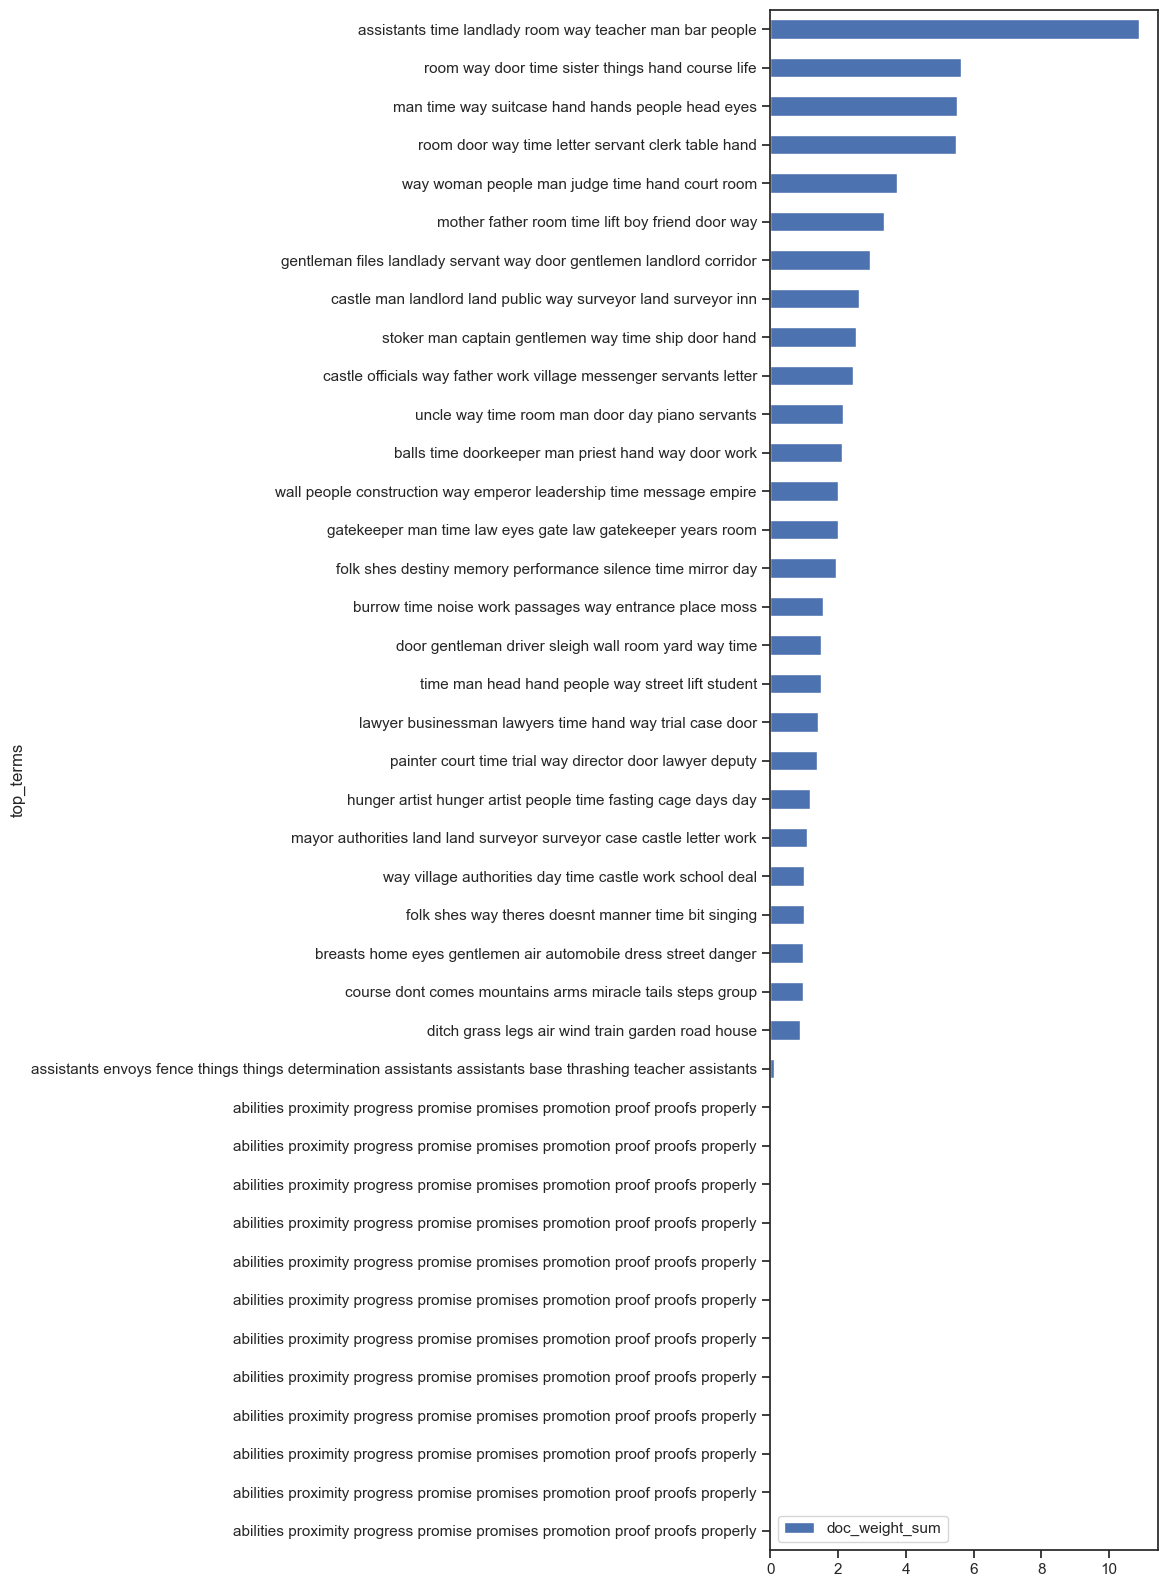

In [104]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='top_terms', figsize=(5, n_topics/2));

<Axes: ylabel='top_terms'>

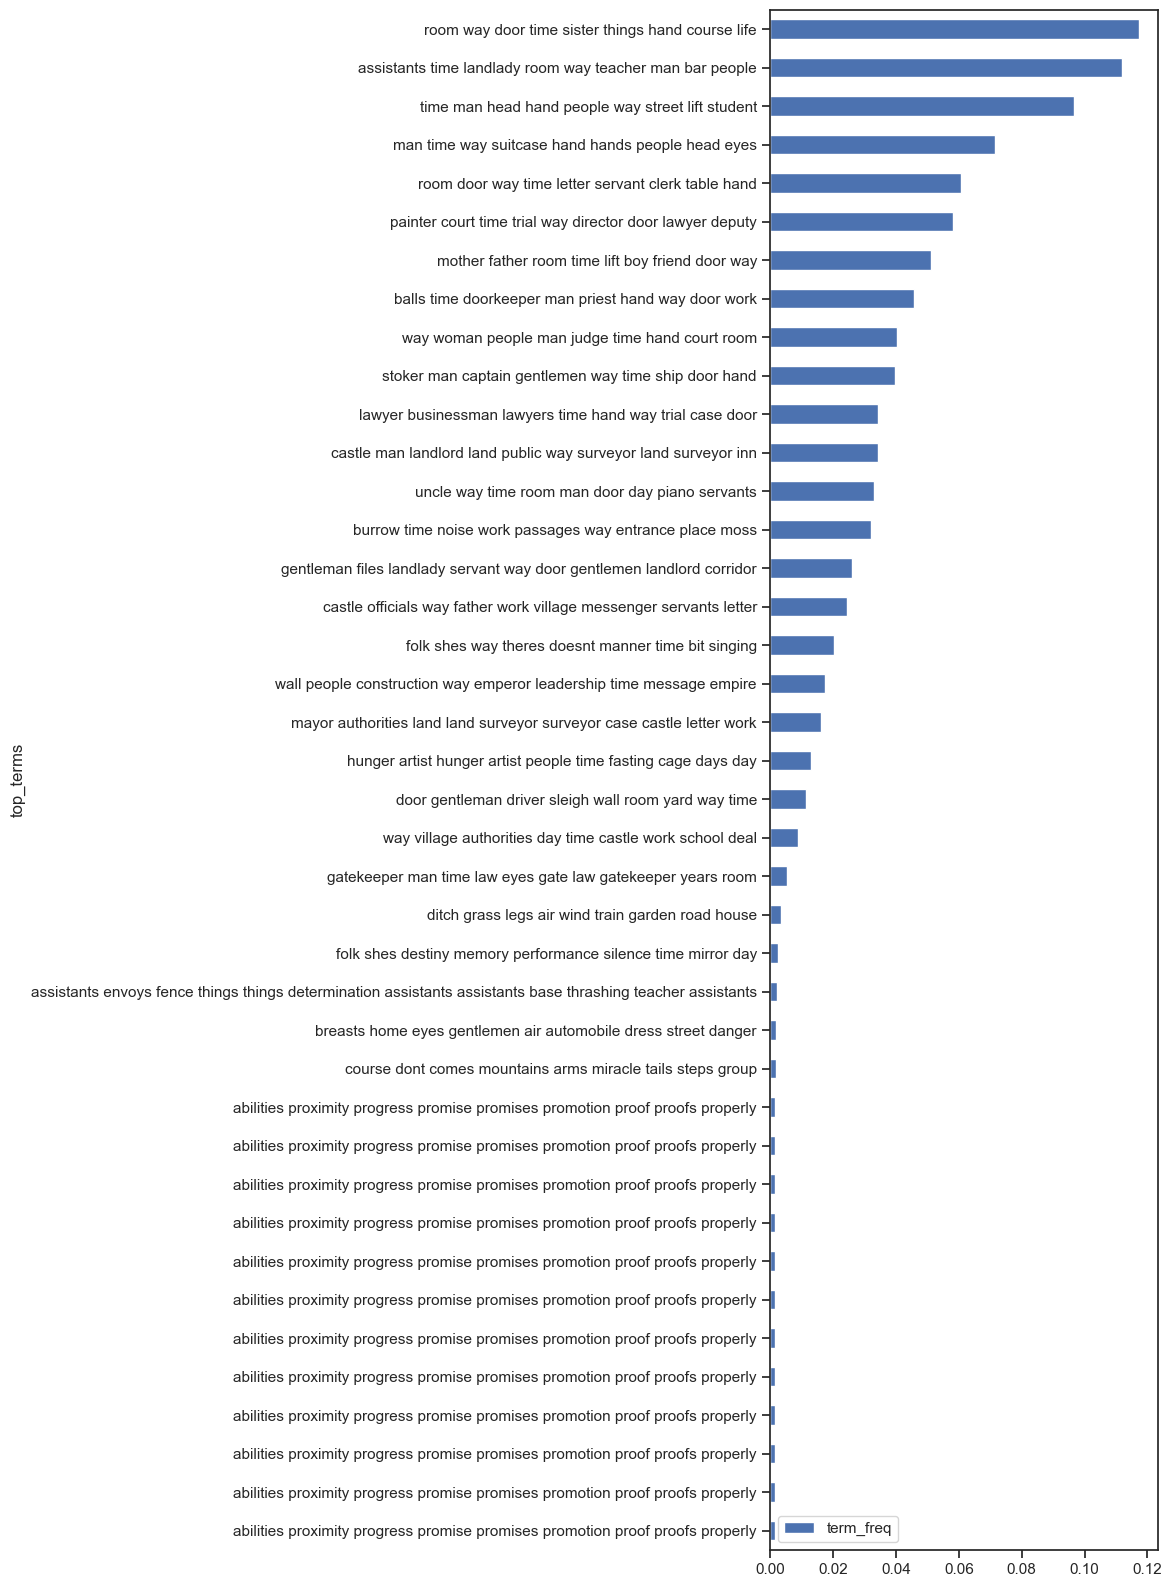

In [105]:
TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='top_terms', figsize=(5, n_topics/2))

#### Apply PCA to the PHI table and plot the topics in the space opened by the first two components.


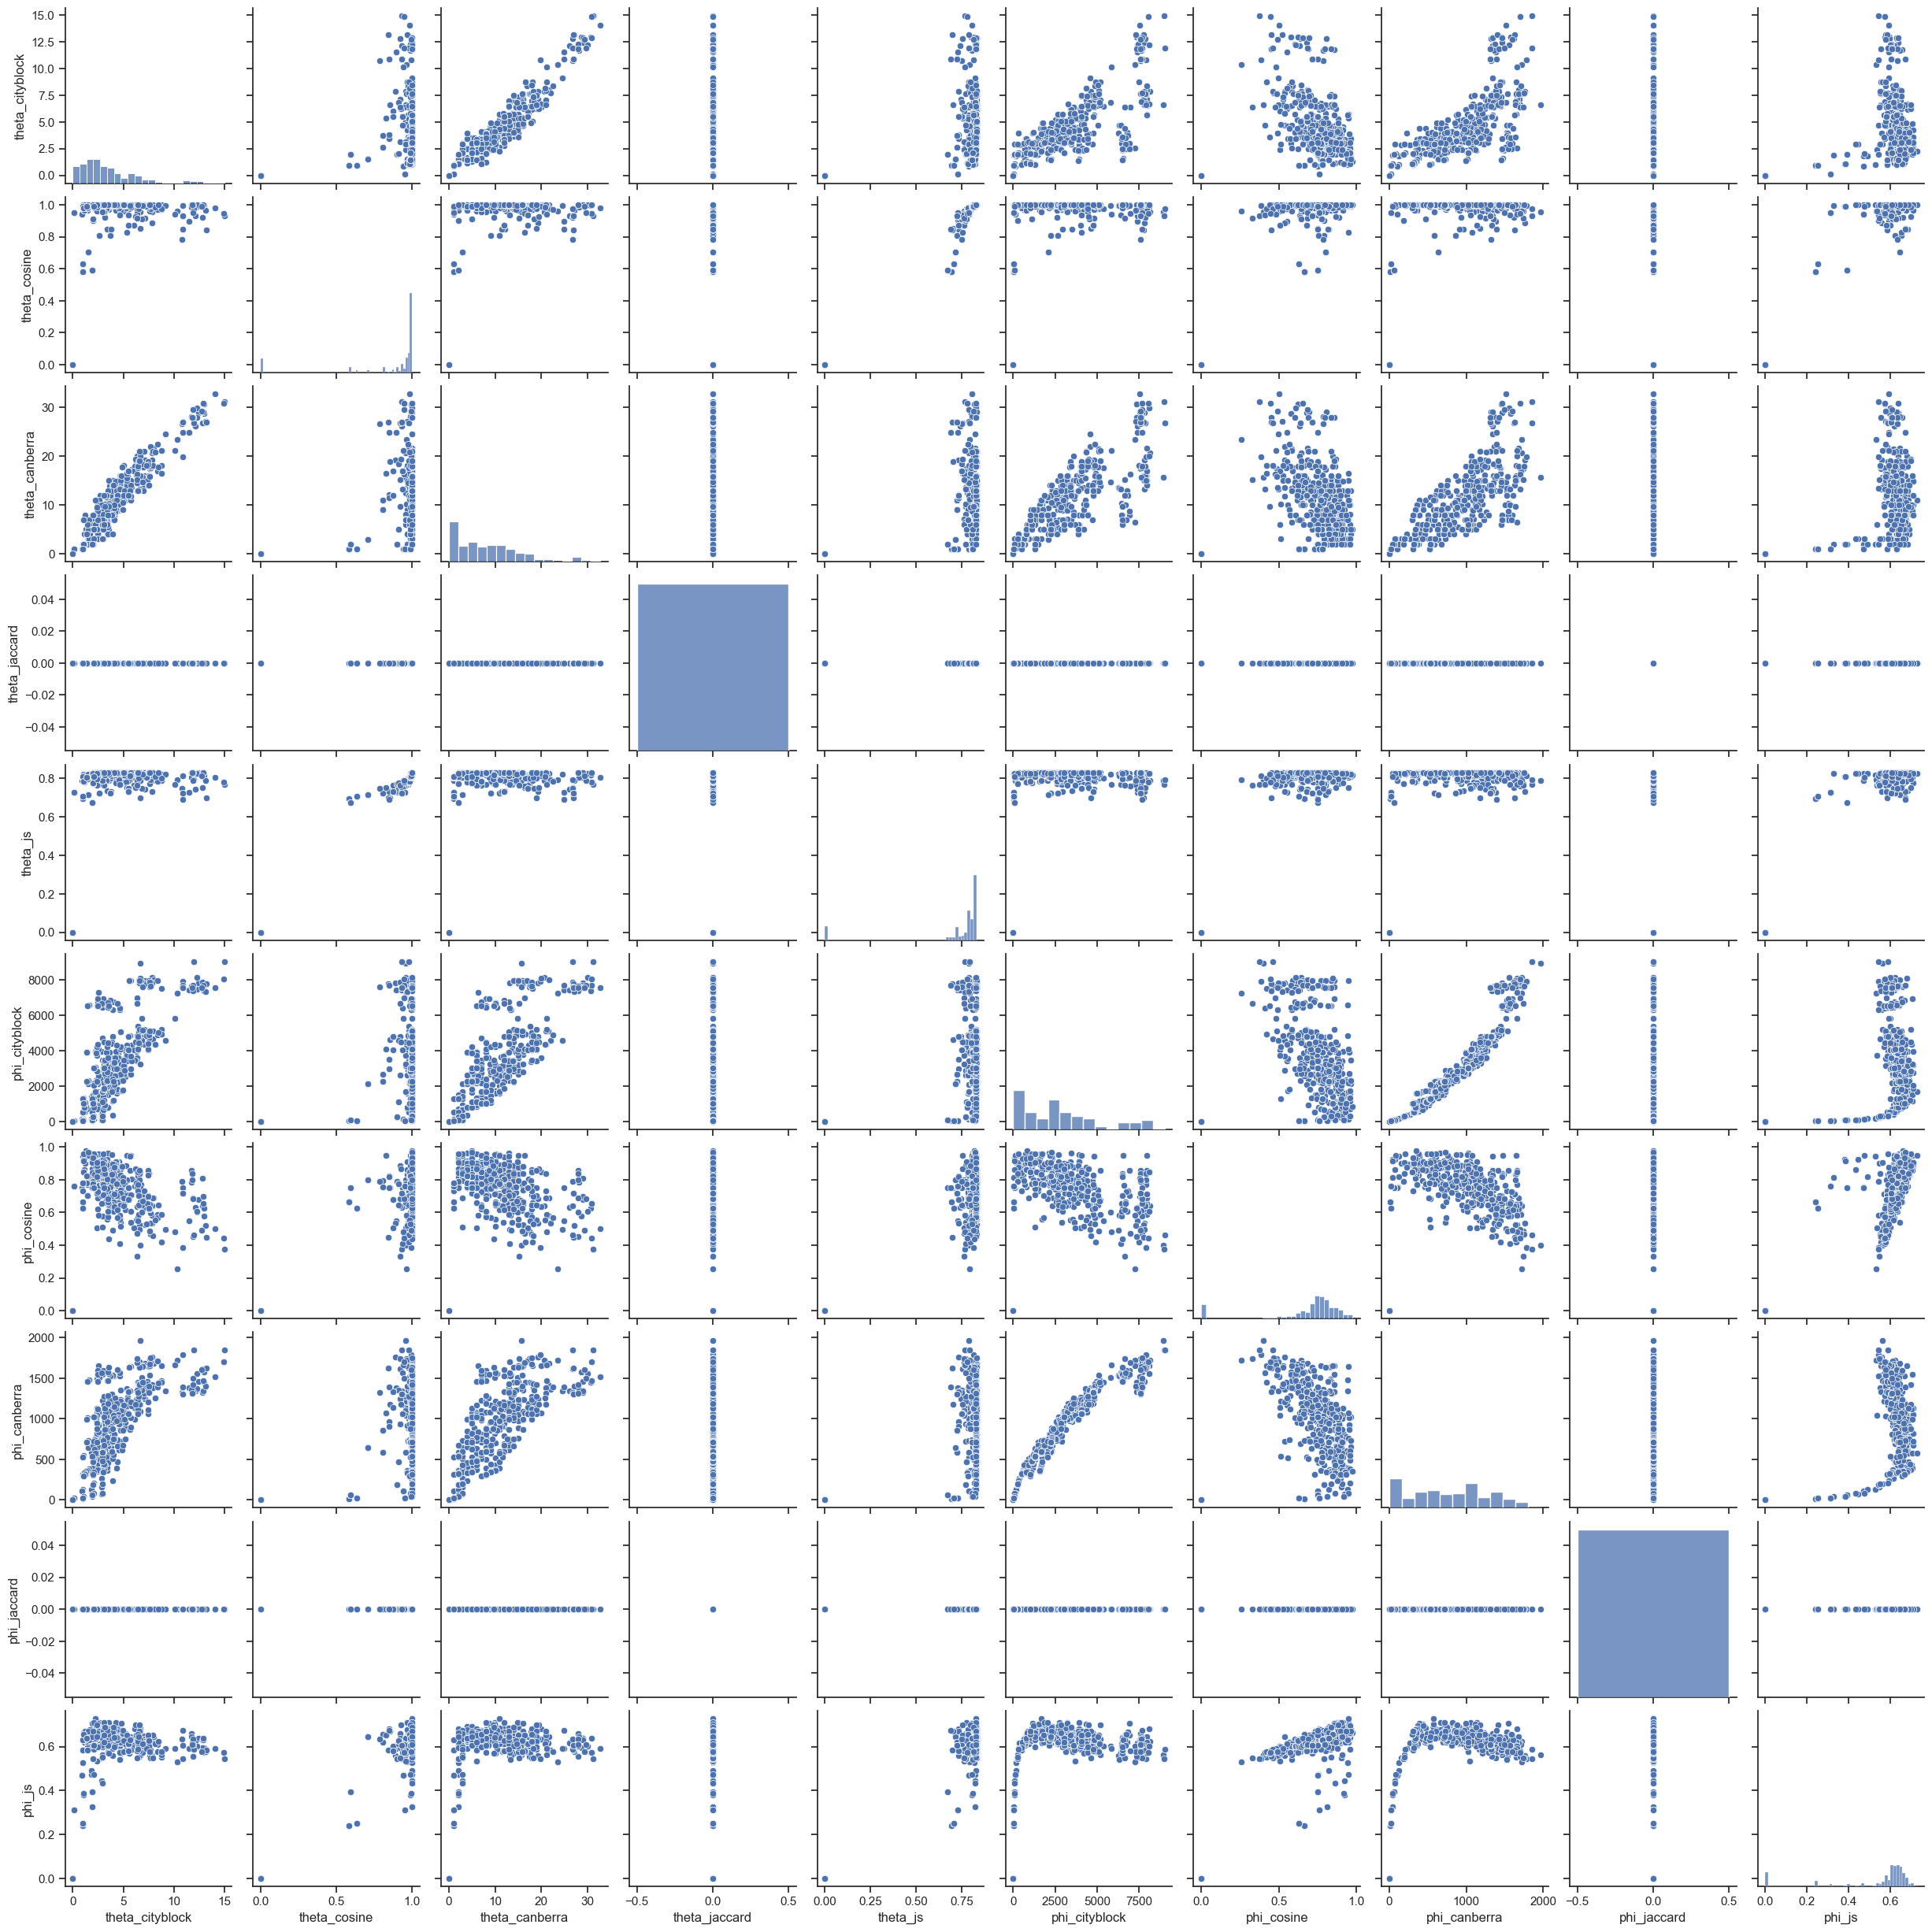

In [108]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist

tpairs_idx = [(a, b) for a, b in pd.MultiIndex.from_product([TOPICS.index, TOPICS.index]) if a < b]
TPAIRS = pd.DataFrame(tpairs_idx, columns=['topic_id_x', 'topic_id_y']).set_index(['topic_id_x', 'topic_id_y'])
TPAIRS['theta_cityblock'] = pdist(THETA.T, 'cityblock')
TPAIRS['theta_cosine'] = pdist(THETA.T, 'cosine')
TPAIRS['theta_canberra'] = pdist(THETA.T, 'canberra')
TPAIRS['theta_jaccard'] = pdist(THETA.T, 'jaccard')
TPAIRS['theta_js'] = pdist(THETA.T, 'jensenshannon')

TPAIRS['phi_cityblock'] = pdist(PHI, 'cityblock')
TPAIRS['phi_cosine'] = pdist(PHI, 'cosine')
TPAIRS['phi_canberra'] = pdist(PHI, 'canberra')
TPAIRS['phi_jaccard'] = pdist(PHI, 'jaccard')
TPAIRS['phi_js'] = pdist(PHI, 'jensenshannon')

sns.pairplot(TPAIRS)

## Okay you still need to figure out how to size the points based on the mean document weight of each topic, then also color points based on category of doc (novel, novella, short story)

## SENTIMENT Vocabs! I think i will combine nrc and gi

In [135]:
import sqlite3
import pandas as pd
import re
bing_pos_file = data_home + '/lexicons/sources/opinion-lexicon-English/positive-words.txt'
bing_neg_file = data_home + '/lexicons/sources/opinion-lexicon-English/negative-words.txt'
nrc_file = data_home + "/lexicons/sources/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
syuzhet_file = data_home + "/lexicons/sources/syuzhet.csv"
gi_file = data_home + "/lexicons/sources/gi.csv"
nrc = pd.read_csv(nrc_file, sep='\t', header=None)
nrc.columns = ['term_str','nrc_emotion','val']
nrc = nrc.set_index(['term_str','nrc_emotion'])
nrc = nrc.unstack()
nrc.columns = nrc.columns.droplevel(0)
nrc = nrc[nrc.sum(1) > 1]
nrc.columns = ['nrc_'+col for col in nrc.columns]
nrc['nrc_sentiment'] =nrc.nrc_positive - nrc.nrc_negative

gi = pd.read_csv(gi_file, index_col=['term_str'])
gi.columns = ['gi_sentiment']
combo = nrc.join(gi, how='outer')\
    .sort_index()
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,nrc_sentiment,gi_sentiment
term_str,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0
abate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
abdicate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [145]:
salex = combo
nrc_cols = "nrc_negative nrc_positive nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_sadness nrc_surprise nrc_trust".split()
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num'] # We exclude genre
CHAPS = OHCO[2:3]
PARAS = OHCO[2:4]
SENTS = OHCO[2:5]
TOKENS.set_index(['book_id']+OHCO)
TOKENS = TOKENS.join(salex, on='term_str', how='left', rsuffix="_new")
TOKENS[nrc_cols] = TOKENS[nrc_cols].fillna(0)
TOKENS[['term_str'] + nrc_cols][TOKENS['nrc_fear'] == 1.0].sample(10)

,term_str,nrc_negative,nrc_positive,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_sadness,nrc_surprise,nrc_trust
73940,malicious,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
288545,disaster,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
121053,cutting,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
357580,ill,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
254846,darkness,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
96931,restrain,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
400059,shame,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
364525,cane,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
143320,absence,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
18281,forced,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


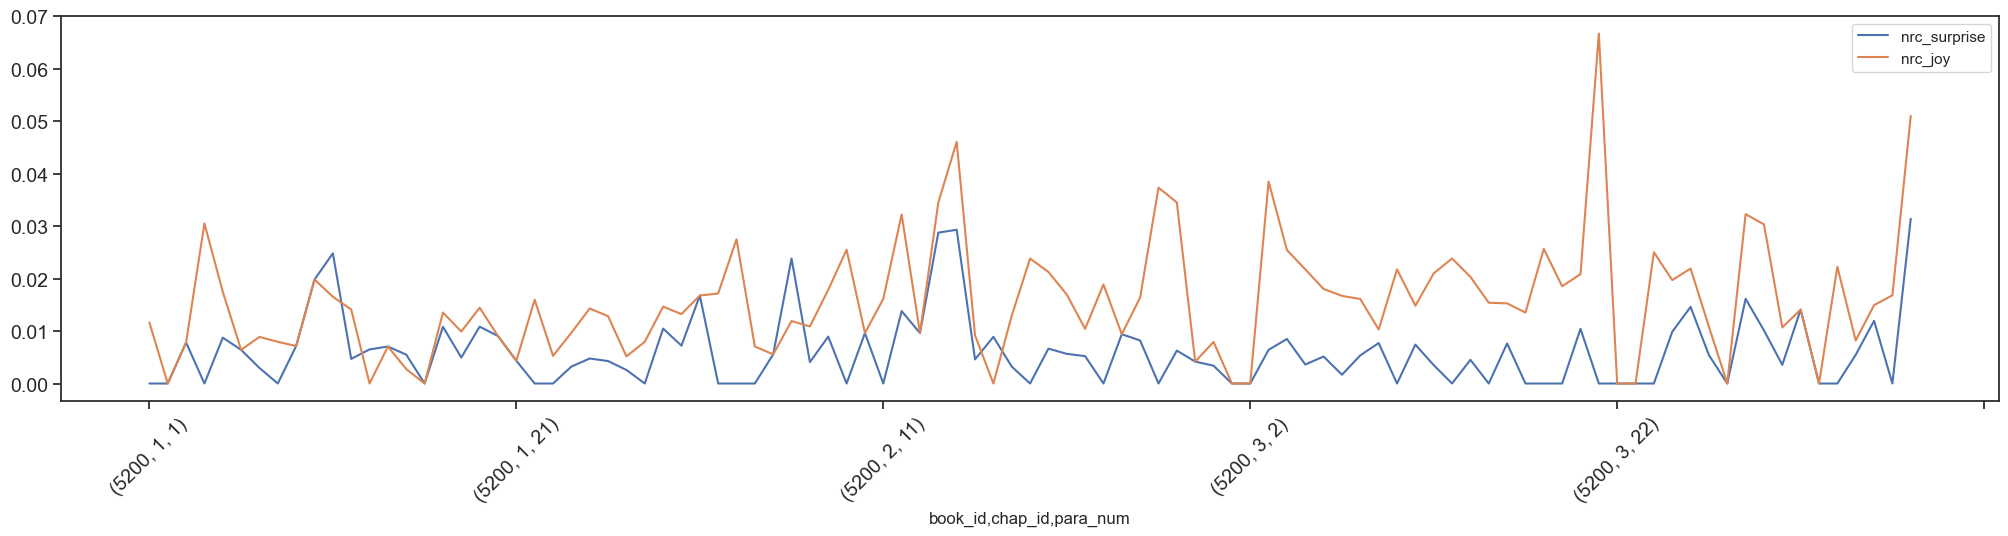

In [191]:
def plot_sentiments(df, emo='sentiment'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

# This chart shows how the family was only happy once they finally got rid of gregor samsa the buggo
plot_sentiments(TOKENS[TOKENS['book_id'] == 5200].groupby(PARA)[nrc_cols].mean(), ['nrc_surprise','nrc_joy'])

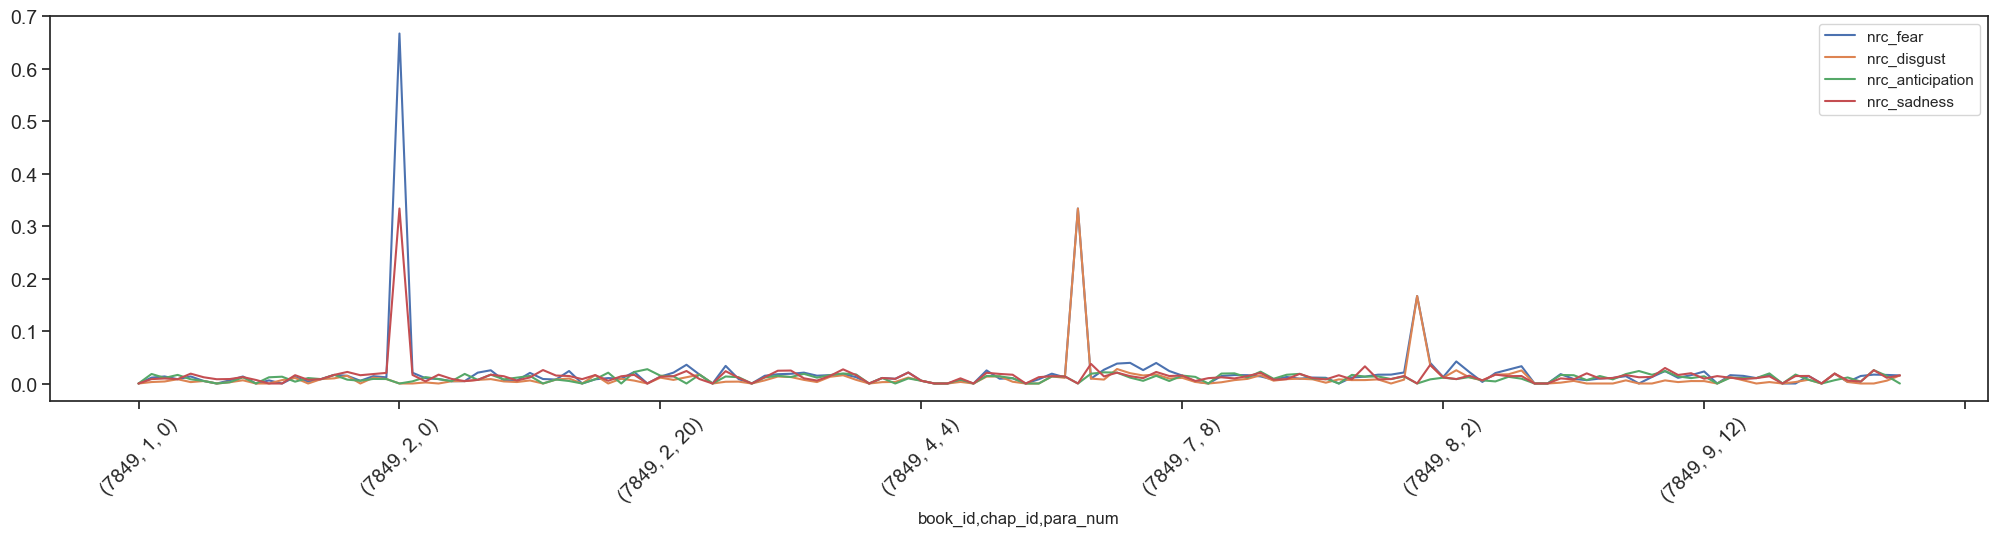

In [ ]:
plot_sentiments(TOKENS[TOKENS['book_id'] == 7849].groupby(PARA)[nrc_cols].mean(), ['nrc_fear','nrc_disgust','nrc_anticipation','nrc_sadness'])

# Plot points in The trial

### Vocab SENT

In [224]:
SALEX = salex.rename(columns={
    'nrc_anger': 'anger',
    'nrc_anticipation': 'anticipation',
    'nrc_disgust': 'disgust',
    'nrc_fear': 'fear',
    'nrc_joy': 'joy',
    'nrc_negative': 'negative',
    'nrc_positive': 'positive',
    'nrc_sadness': 'sadness',
    'nrc_surprise': 'surprise',
    'nrc_trust': 'trust',
    'nrc_sentiment': 'nrc_sentiment',
    'gi_sentiment': 'gi_sentiment'
})

CORPUS = tokenize_collection(LIB)
CORPUS = CORPUS[CORPUS.term_str != '']
CORPUS['pos_group'] = CORPUS.pos.str[:2]

VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['max_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['n_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack().count(1)
VOCAB['cat_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos_group.apply(lambda x: set(x))
VOCAB['n_pos'] = CORPUS[['term_str','pos']].value_counts().unstack().count(1)
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['porter_stem'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)


V = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)
V.head()

Tokenizing 5200 METAMORPHOSIS
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5200.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^\s*[IVXLCM]+\s*$
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 5252 BLUMFELD
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5252.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone NOCHAPTERS
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 5353 THE BURROW
Importing  /Users/muhur/OneDrive/Desktop/Muhurto/Data Science Grad School/DS5001/KafkaFinal/data\pg5353.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone NOCHAPTERS
li

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,...,disgust,fear,joy,negative,positive,sadness,surprise,trust,nrc_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,,,,,,,
abandon,6,7,0.000014,16.105653,VB,VB,2,"{JJ, VB}",3,"{JJ, VB, VBP}",...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,-1.0
abandoned,21,9,0.000050,14.298298,VBN,VB,4,"{JJ, NN, VB, RP}",5,"{JJ, VBN, VBD, RP, NN}",...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,NaN
abduction,1,9,0.000002,18.690615,NN,NN,1,{NN},1,{NN},...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,NaN
abhorrent,2,9,0.000005,17.690615,JJ,JJ,1,{JJ},1,{JJ},...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,NaN
ability,10,7,0.000024,15.368687,NN,NN,1,{NN},1,{NN},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


# Lets try BOW

In [240]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust gi_sentiment nrc_sentiment".split()
B = BOWofCORPUSwithTFIDF.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna().set_index(['book_id','chap_id','term_str'])
B

n     tfidf max_pos  anger  anticipation  disgust  \
book_id chap_id term_str                                                        
5200    1       afraid      2  0.004791      JJ    0.0           0.0      0.0   
                alarm       3  0.014120      NN    0.0           0.0      0.0   
                anger       1  0.006047      NN    1.0           0.0      0.0   
                anxious     1  0.004899      JJ    0.0           1.0      0.0   
                attack      1  0.005317      NN    1.0           0.0      0.0   
...                        ..       ...     ...    ...           ...      ...   
23532   10      unbearable  1  0.038627      JJ    0.0           0.0      1.0   
                upright     1  0.017957      JJ    0.0           0.0      0.0   
                wild        1  0.020197      JJ    0.0           0.0      0.0   
                wisdom      1  0.041213      NN    0.0           0.0      0.0   
                worry       1  0.025842      VB    0.0           1.0      0.0   

                            fear  joy  sadness  surprise  trust  gi_sentiment  \
book_id chap_id term_str                                                        
5200    1       afraid       1.0  0.0      0.0       0.0    0.0          -1.0   
                alarm        1.0  0.0      0.0       1.0    0.0          -1.0   
                anger        0.0  0.0      0.0       0.0    0.0          -1.0   
                anxious      1.0  0.0      0.0       0.0    0.0          -1.0   
                attack       1.0  0.0      0.0       0.0    0.0          -1.0   
...                          ...  ...      ...       ...    ...           ...   
23532   10      unbearable   0.0  0.0      1.0       0.0    0.0          -1.0   
                upright      0.0  0.0      0.0       0.0    1.0           1.0   
                wild         0.0  0.0      0.0       1.0    0.0          -1.0   
                wisdom       0.0  0.0      0.0       0.0    1.0           1.0   
                worry        1.0  0.0      1.0       0.0    0.0          -1.0   

                            nrc_sentiment  
book_id chap_id term_str                   
5200    1       afraid               -1.0  
                alarm                -1.0  
                anger                -1.0  
                anxious              -1.0  
                attack               -1.0  
...                                   ...  
23532   10      unbearable           -1.0  
                upright               1.0  
                wild                 -1.0  
                wisdom                1.0  
                worry                -1.0  

[5494 rows x 13 columns]

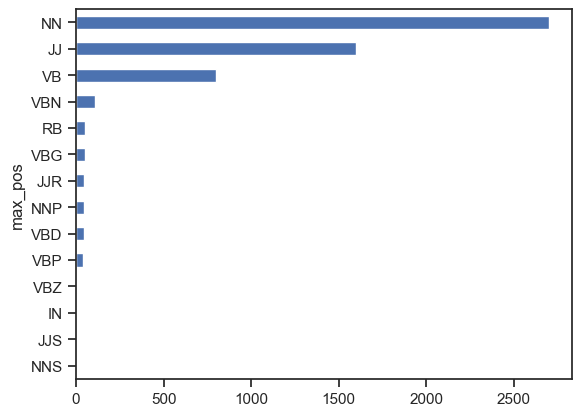

In [ ]:
for col in emo_cols:
    B[col] = B[col] * B.tfidf
B.max_pos.value_counts().sort_values().plot.barh();

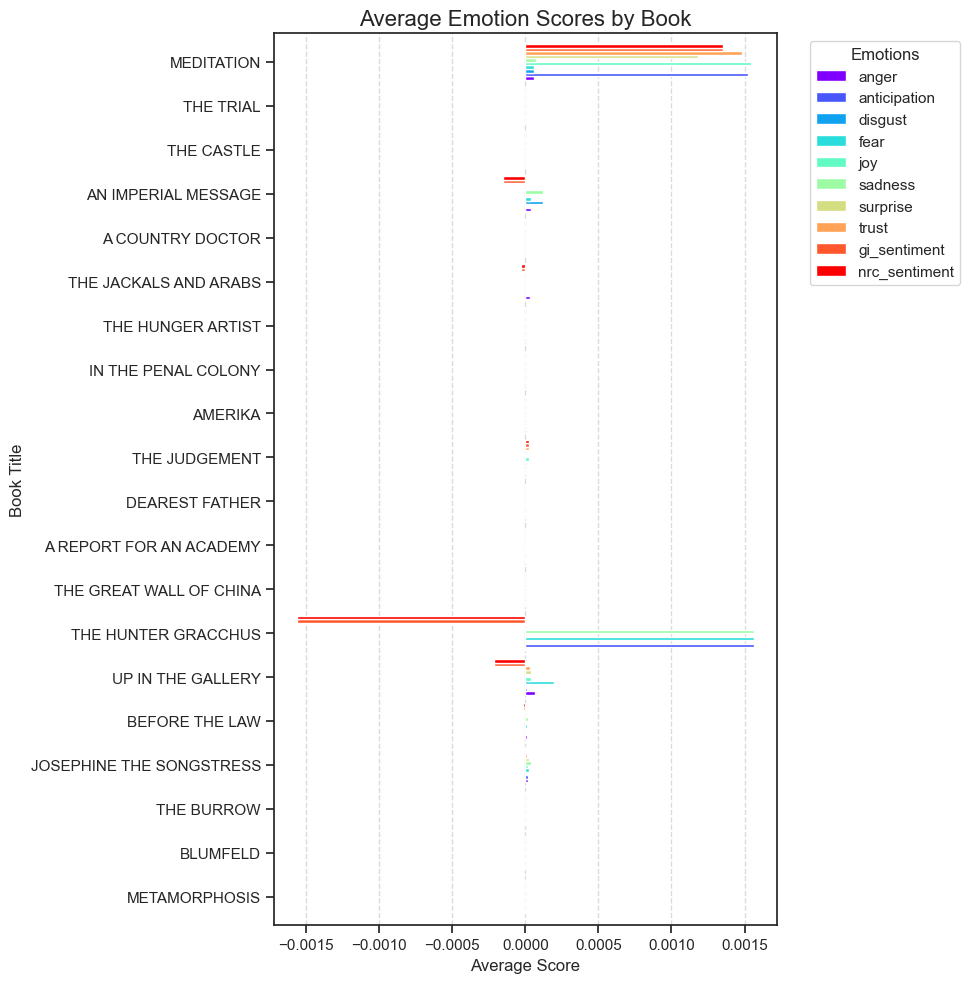

In [ ]:
import matplotlib.pyplot as plt

# Group and plot
EMO_BOOKS = B.groupby(['book_id'])[emo_cols].mean()
EMO_BOOKS.index = LIB.title  # Replace book_id with readable titles

# Plotting
ax = EMO_BOOKS.plot.barh(
    figsize=(10, 10),
    width=0.8,               # Adjust bar thickness
    colormap='rainbow',      # Optional: use a more vibrant colormap
)

# Layout & Style Tweaks
plt.title("Average Emotion Scores by Book", fontsize=16)
plt.xlabel("Average Score", fontsize=12)
plt.ylabel("Book Title", fontsize=12)

plt.legend(title="Emotions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjusts padding to avoid clipping labels

plt.grid(axis='x', linestyle='--', alpha=0.7)  # Optional: gridlines for readability

plt.show()

## VOCAB_W2V

In [285]:
OHCO = ['book_id', 'sent_num', 'token_num']
# PARA = OHCO[:4] # Paragraphs
# SENT = OHCO[:5] # Sentences
BAG = OHCO[:1]
# BAG = SENT

# word2vec parameters
w2v_params = dict(
    window = 2,
    vector_size = 200,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)
import gensim
import pandas as pd
import numpy as np
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne
import plotly_express as px

ImportError: cannot import name 'open' from 'smart_open' (unknown location)

In [ ]:
docs = TOKENS.dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs
vocab = Dictionary(docs)
model = word2vec.Word2Vec(docs, **w2v_params)
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
WV

NameError: name 'Dictionary' is not defined

[['one', 'morning', 'when', 'gregor', 'samsa', 'woke', 'from', 'troubled', 'dreams', 'he', 'found', 'himself', 'transformed', 'in', 'his', 'bed', 'into', 'a', 'horrible', 'vermin', 'he', 'lay', 'on', 'his', 'armour', 'like', 'back', 'and', 'if', 'he', 'lifted', 'his', 'head', 'a', 'little', 'he', 'could', 'see', 'his', 'brown', 'belly', 'slightly', 'domed', 'and', 'divided', 'by', 'arches', 'into', 'stiff', 'sections', 'the', 'bedding', 'was', 'hardly', 'able', 'to', 'cover', 'it', 'and', 'seemed', 'ready', 'to', 'slide', 'off', 'any', 'moment', 'his', 'many', 'legs', 'pitifully', 'thin', 'compared', 'with', 'the', 'size', 'of', 'the', 'rest', 'of', 'him', 'waved', 'about', 'helplessly', 'as', 'he', 'looked', 'whats', 'happened', 'to', 'me', 'he', 'thought', 'it', 'wasnt', 'a', 'dream', 'his', 'room', 'a', 'proper', 'human', 'room', 'although', 'a', 'little', 'too', 'small', 'lay', 'peacefully', 'between', 'its', 'four', 'familiar', 'walls', 'a', 'collection', 'of', 'textile', 'samples

In [290]:
LIB.to_csv('tempLIB.csv')

In [291]:
CORPUS.to_csv('tempCORPUS.csv')

In [292]:
VOCAB.to_csv('tempVOCAB.csv')